# Top-hat beam propagation using fourier optics

First some inports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from efield import EField

Let's define a Fermi-Dirac function

In [2]:
def fermidirac(x, A, R0, x0, b):
    e = np.exp(-b*(abs(x-x0)/R0-1))
    return A*e/(1+e)

We define the fermi dirac beam parameters : radius and beta factor.

We define a linspace x, which spans over 6 radiuses, with a number of points which is a power of two to speed up the calculations.

Finally we define our EM Field EField with the linspace, the fermidirac electric field shape and wavelength.

In [3]:
R0, b = 0.5e-3, 16.25
nx = 2**12

x = np.linspace(-3*R0, 3*R0, nx)

E = EField(x, E=fermidirac(x, A=1, R0=R0, x0=0, b=b))

We create a canvas to plot EFields. This is just a figure with two subplots for intensity and phase with according labels.

We then plot the initial field to this figure and then propagate it a few times while showing the resulting field.

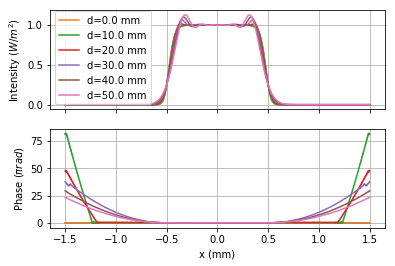

In [4]:
fig, (axI, _) = EField.create_figure()

E.plot(fig=fig)
for d in np.linspace(0, 50e-3, 6):
    E_prop = E.propagate(d)
    E_prop.plot(fig=fig, label=f'd={d*1000:.1f} mm')

axI.legend()
plt.show()

## Propagation of a top-hat with phase noise

We define a small function to generate random smooth maps. It just takes a number of points and a coherence length (rapported to 1) of the randomness.

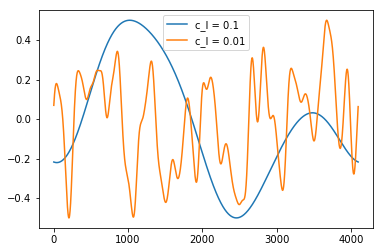

In [13]:
import scipy.fftpack as sf

def generate_map(N, c_l):
    y = np.random.randn(N)
    x = np.linspace(-0.5, 0.5, N)
    F = np.exp(-0.5 * x**2 / c_l**2)
    res = 1 / c_l / np.sqrt(np.pi) * (sf.ifft(sf.fft(F) * sf.fft(y))).real
    return (res - res.min())/(res.max() - res.min()) - 0.5

plt.subplots()
plt.plot(generate_map(2**12, 0.1), label='c_l = 0.1')
plt.plot(generate_map(2**12, 0.01), label='c_l = 0.01')
plt.legend()
plt.show()

We import the FD_efield class which allows us to create FermiDirac top-hat EFields directly. We define a coherence length and peak-peak phase amplitude. We generate the map and apply it to the field.

In [38]:
from efield.efields import FD_efield

R0, b = 7.5e-3, 16.25
nx = 2**12
xm = 3*R0
c_l = 1e-3
pp_phase = 2*np.pi / 3

x = np.linspace(-xm, xm, nx)
E = FD_efield(x=x, R0=R0, b=b)
phase_map = generate_map(nx, c_l / (2*xm)) * pp_phase

E *= np.exp(1j*phase_map)

We create a figure to plot the EFields, and a figure to plot the relative phases of the beam before and after propagation.

We propagate the beam on a distance of 300 mm and calculate the relative phase. We offset this relative phase to only see the transverse difference.

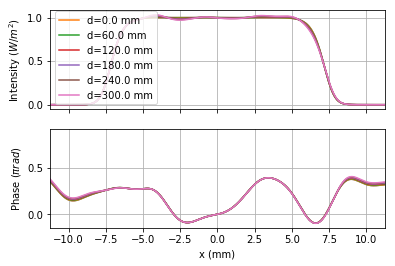

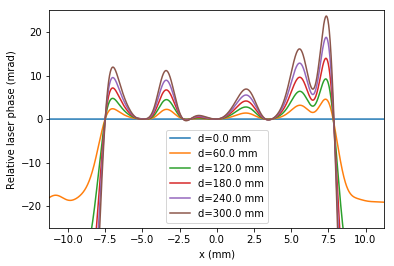

In [39]:
fig, (axI, _) = EField.create_figure()
axI.set_xlim(-1.5*R0*1e3, 1.5*R0*1e3)

fig_relphase, ax_relphase = plt.subplots()
ax_relphase.set_ylim(-25, 25)
ax_relphase.set_xlim(-1.5*R0*1e3, 1.5*R0*1e3)
ax_relphase.set_xlabel('x (mm)')
ax_relphase.set_ylabel('Relative laser phase (mrad)')

E.plot(fig=fig)

for d in np.linspace(0, 300e-3, 6):
    label = f'd={d*1000:.1f} mm'
    E_prop = E.propagate(d)
    E_prop.plot(fig=fig, label=label)

    relative_phase = E_prop.phase - E.phase
    relative_phase = np.unwrap(relative_phase)

    relative_phase -= relative_phase[nx // 2]
    ax_relphase.plot(x * 1e3, relative_phase * 1e3,
                     label=label)

axI.legend()
ax_relphase.legend()


plt.show()
